# Spectral Comparison Plots #
**Generated at 2019-09-14**

**data1 git hash b'cda9066ba782303e42f0eb47c7d99380b46e030b'**

In [34]:
import os, itertools
import pandas as pd
import numpy as np

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.palettes import Dark2_5, colorblind
from glob import glob

from bokeh.layouts import layout, column, row
from bokeh.models.widgets import Tabs, Panel
from bokeh.io import curdoc
from bokeh.plotting import figure
from scipy import interpolate, integrate

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [35]:
def read_magnitudes(fname):
    COL_NAMES = ['time', 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
    mag_table = pd.read_csv(fname, delim_whitespace=True, comment='#', names=COL_NAMES)
    mag_table.iloc[:, 1:] = mag_table.iloc[:,1:].replace(99.999, np.nan)
    return mag_table
    
def read_spectrum(fname):
    col_names = ['wavelength']
    with open(fname, encoding='utf8') as fh:
        for i, line in enumerate(fh):
            if i==2:
                times = list(map(np.float64, line.strip().split(':')[1].split()))
    
    spectrum = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None)
    spectrum.columns = col_names + times
    return spectrum

def read_tgas(fname):
    col_names = ['velocity']
    with open(fname, encoding='utf8') as fh:
        for i, line in enumerate(fh):
            if i==2:
                times = list(map(np.float64, line.strip().split(':')[1].split()))
    
    spectrum = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, names=col_names + times)
    return spectrum

In [36]:
# uncomment the following line to download the code comparison stuff
#!wget http://opensupernova.org/~wkerzend/files/ccompare1_models.tgz
#!tar zxf ccompare1_models.tgz

# Comparison Parameters

Set the `CODE_NAMES` list to include codes in the plots.

Set the `CODE_COLORS` variable to change the color scheme.

Set the `MODEL_NAME` to change the model for the plots.

In [85]:
CODE_NAMES = ['artis', 'cmfgen', 'sedona', 'stella', 'sumo', 'supernu', 'urilight']
CODE_COLORS = {name:color for name, color in zip(CODE_NAMES, colorblind['Colorblind'][8])}
MODEL_NAME = 'toy06'

## Interactive Spectra Comparison ##

In [86]:
## Reading the data
spectral_data = {}
for code_name in CODE_NAMES:
    fname = '../data1/{1}/spectra_{1}_{0}.txt'.format(code_name,MODEL_NAME)
    if not os.path.exists(fname):
        continue
    try:
        spectral_data[code_name] = read_spectrum(fname)
    except UnicodeDecodeError:
        print('File {0} does raise a UnicodeDecodeError'.format(fname))
        pass
    except IndexError:
        print('File {0} does raise a IndexError'.format(fname))
        pass
    except ValueError:
        print('File {0} does raise a ValueError'.format(fname))
        pass

In [87]:
SPECTRAL_TIMES = [5, 10, 15, 20, 30, 50, 100, 200, 300, 400]
output_notebook()
interpolators = {}
for name in CODE_NAMES:
    if name not in spectral_data:
        continue
    time = spectral_data[name].columns.values
    try:
        time = time[1:].astype(np.float64)
        spectra = spectral_data[name].iloc[:, 1:].values.astype(np.float64)
    except ValueError:
        print("Spectral data from code {0} has problems".format(name))
        continue
    interpolators[name] = interpolate.interp1d(time, spectra, fill_value=np.nan, bounds_error=False)

all_tabs = []
for time in SPECTRAL_TIMES:
    fig = figure()
    for name, interpolator in interpolators.items():
        wavelength = spectral_data[name].wavelength
        fig.line(wavelength, interpolator(time), legend=name, line_width=2, color=CODE_COLORS[name])
    fig.legend.location = "top_right"
    fig.legend.click_policy="hide"
    lout = layout([[fig]])
    tab = Panel(child=lout,title='t={0:.0f}'.format(time))
    all_tabs.append(tab)
        
show(Tabs(tabs=all_tabs))

Loading BokehJS ...

## Spectral Comparison Plots ##

In [88]:
import matplotlib.pyplot as plt

/Users/marcwilliamson/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


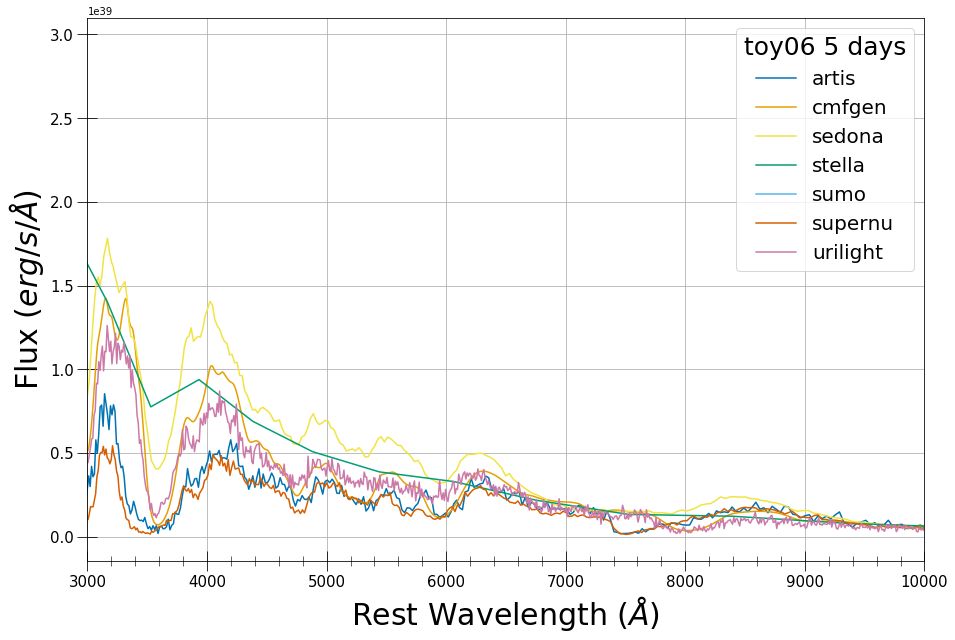

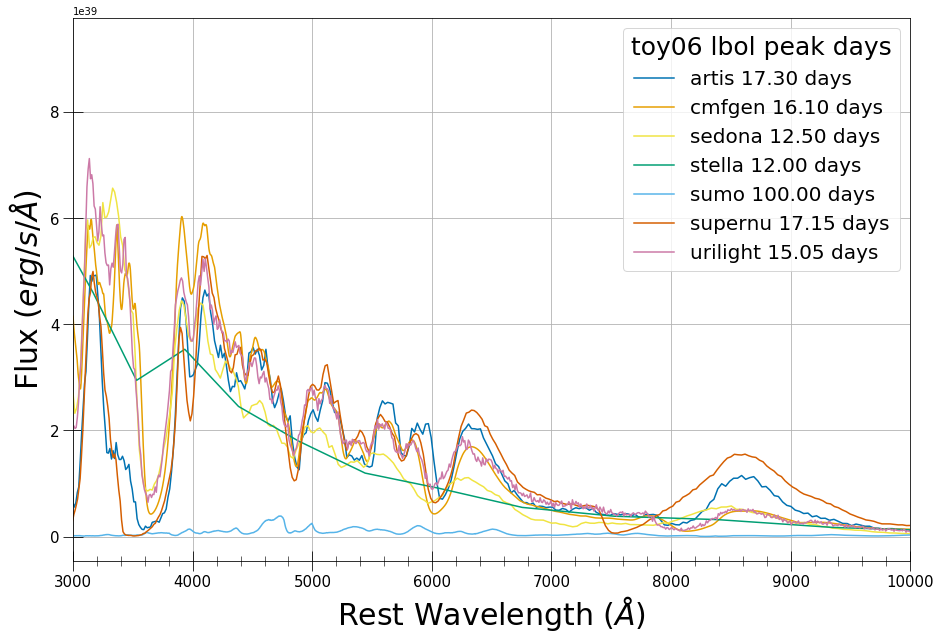

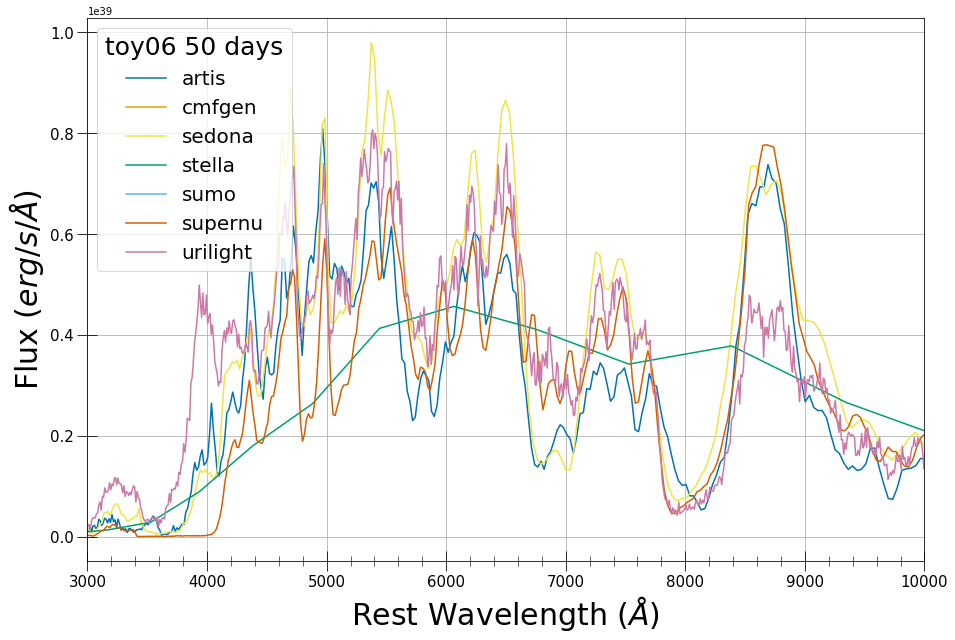

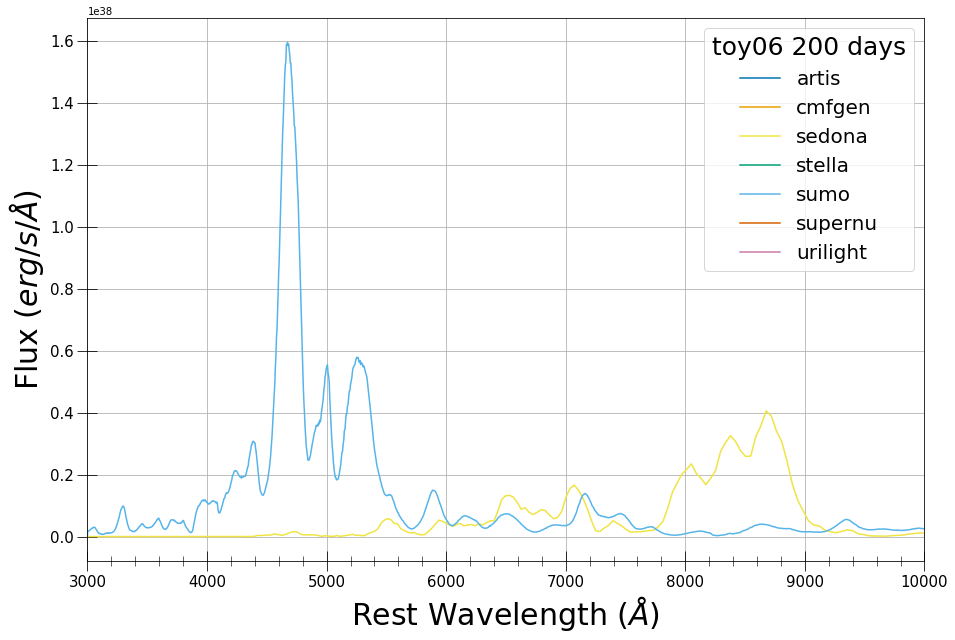

In [89]:
def get_lbol_peak_time(name):
    fname = '../data1/{1}/lbol_edep_{1}_{0}.txt'.format(name, MODEL_NAME)
    lbol = pd.read_csv(fname, delim_whitespace=True, comment='#', names=['time', 'lbol','edep'])
    peak_ind = np.argmax(np.log10(lbol.lbol.values))
    peak_time = lbol.time.values[peak_ind]
    return peak_time

SPECTRAL_TIMES = [5, 'lbol peak', 50, 200]
wvl_range = (3000, 10000)
figs = []

interpolators = {}
for name in CODE_NAMES:
    if name not in spectral_data:
        continue
    time = spectral_data[name].columns.values
    try:
        time = time[1:].astype(np.float64)
        spectra = spectral_data[name].iloc[:, 1:].values.astype(np.float64)
    except ValueError:
        print("Spectral data from code {0} has problems".format(name))
        continue
    interpolators[name] = interpolate.interp1d(time, spectra, fill_value=np.nan, bounds_error=False)


for time in SPECTRAL_TIMES:
    fig = plt.figure(figsize=(15,10))
    
    for name, interpolator in interpolators.items():
        if time == 'lbol peak':
            peak_time = get_lbol_peak_time(name)

        wavelength = spectral_data[name].wavelength
        if time == 'lbol peak':
            plt.plot(wavelength, interpolator(peak_time), label='%s %.2f days'%(name, peak_time), color=CODE_COLORS[name])
        else:
            plt.plot(wavelength, interpolator(time), label=name, color=CODE_COLORS[name])

    
    ax = fig.gca()
    ax.set_xlabel("Rest Wavelength $(\AA)$", fontsize=30)
    ax.set_ylabel("Flux $(erg / s / \AA)$", fontsize=30)
    
    ax.set_xlim(wvl_range)
    
    ax.xaxis.set_minor_locator(plt.MultipleLocator(200))
    
    ax.tick_params(axis='both', which='major', direction='inout', length=20, labelsize=15)
    ax.tick_params(axis='x', which='minor', direction='inout', length=10)
    plt.grid(True)
    
    ax.legend(fontsize=20, title='{1} {0} days'.format(time, MODEL_NAME), title_fontsize=25)
    figs.append(fig)
        


In [90]:
# The above figures are stored in the figs list for further modifications.
figs

[<Figure size 1080x720 with 1 Axes>,
 <Figure size 1080x720 with 1 Axes>,
 <Figure size 1080x720 with 1 Axes>,
 <Figure size 1080x720 with 1 Axes>]